In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

## The Advanced Computing Center for Research and Education

**Project Overview**
The Advanced Computing Center for Research and Education (ACCRE) operates Vanderbilt University's high-performance computing cluster. Jobs submitted to ACCRE are managed by the [slurm scheduler](https://slurm.schedmd.com/documentation.html), which tracks compute and memory resources.

ACCRE staff have hypothesized that the scheduler sometimes becomes unresponsive because it is processing large bursts of job completions. This especially affects automated job submitters, such as members of the Open Science Grid.

Your goal is to evaluate whether the data supports the hypothesis of bursts of job completions contributing to scheduler unresponsiveness.

You are provided three datasets:  
* fullsample.csv: Contains slurm job records. Job completions correspond to jobs in the "COMPLETED" state with exit code "0:0".  
* slurm_wrapper_ce5.log, slurm_wrapper_ce6.log: These log files contain every slurm command executed by the CE5 and CE6 servers (gateways to the Open Science Grid).  
Unresponsive periods are indicated by "sbatch" commands from user 9204 that have:  
    * return code = 1
    * execution time > 15 seconds

**Phase 1: Explore the Data**  
Objectives:  
* Understand the purpose of each dataset.  
* Inspect column types, sizes, and example rows.  

Notebook Sections:  
* Code: Load each dataset, preview rows, summarize columns.  
* Markdown: Notes on data quality and initial observations.  

In [2]:
# Read csv file
jobs = pd.read_csv('../data/fullsample.csv')

In [3]:
# Read log file
ce5 = pd.read_csv('../data/slurm_wrapper_ce5.log',
                  header=None,
                  delimiter=' - ',
                  engine='python')

In [4]:
# Read log file
ce6 = pd.read_csv('../data/slurm_wrapper_ce6.log',
                  header=None,
                  delimiter=' - ',
                  engine='python')

> ## Dataset Overview
>
> 
> This project analyzes job activity in Vanderbilts **open source science grid.** We have three primary data sets to analyze in this project. Below is a table to define each column in the "jobs" dataset. This dataset contains historical records of jobs submitted to the [ACCRE Slurm Scheduler](https://slurm.schedmd.com/documentation.html). The other two dataframes contain unresponsive events or recordings of servers that are not working properly.
>
>* Create table defining variables in jobs dataframe
>* Inspect Variable types and explore data
>* **0.28%** of the jobs in this dataset are not complete.

column | description
-------|---------
JOBID | The identification number of the job or job step. Array jobs are in the form ArrayJobID_ArrayTaskID
STATE | Job state or status (COMPLETED, CANCELLED, FAILED, TIMEOUT, PREEMPTED, etc.)
BEGIN | Beginning time for the job.
END | Ending time for the job.
REQMEM | Requested memory in megabytes. May be per-core (Mc) or per-node (Mn)
USEDMEM | Used memory in megabytes per-node
REQTIME | Requested time in d-hh:mm:ss or hh:mm:ss
USEDTIME | Used time in d-hh:mm:ss or hh:mm:ss
NODES | Number of servers used for this job
CPUS | Total number of CPU-cores allocated to the job
PARTITION | Identifies the partition on which the job ran.
EXITCODE | The exit code returned by the job script or salloc, typically as set by the exit() function. Following the colon is the signal that caused the process to terminate if it was terminated by a signal.

In [5]:
# Inspect variable types
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 12 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   JOBID      object
 1   STATE      object
 2   BEGIN      object
 3   END        object
 4   REQMEM     object
 5   USEDMEM    object
 6   REQTIME    object
 7   USEDTIME   object
 8   NODES      int64 
 9   CPUS       int64 
 10  PARTITION  object
 11  EXITCODE   object
dtypes: int64(2), object(10)
memory usage: 677.1+ MB


In [6]:
# Find incomplete jobs
jobs['STATE'].describe()

count       7395885
unique          145
top       COMPLETED
freq        7375084
Name: STATE, dtype: object

In [7]:
# Calculate sample statistic
print(f'{(((7395885 - 7375084) / 7395885) * 100):.2f}% of the jobs in this dataset are not completed.')

0.28% of the jobs in this dataset are not completed.


In [42]:
# Inspect size of dataframes
(jobs.shape,
ce5.shape,
ce6.shape)

((7395885, 12), (4770893, 8), (4776520, 8))

> ## Clean and Sort Data
>
> We have analyzed the "jobs" csv file and gained an understanding of the data. We have two other dataframes we want to better understand. The log files we have imported are messy and need some adjustment. Below, we will rename each column and identify its purpose. This will give us a better idea of how we can merge and analyze this data.
> 
>
>* **Rename columns** with descriptive indicators.
>* Eliminate unnecesary information.
>* Create seperate **date and time** columns.
>
>

In [8]:
ce5 = pd.DataFrame(ce5)

# Rename columns
ce5 = ce5.rename(
    columns={
        0: 'date_time',
        1: 'user',
        2: 'retry',
        3: 'runtime',
        4: 'return_code',
        5: 'command'
    }
)

In [9]:
# Clean and strip column values
ce5['user'] = ce5['user'].str.replace(r'^user\s*', '', regex=True)
ce5['retry'] = ce5['retry'].str.replace(r'^retry\s*', '', regex=True)
ce5['runtime'] = ce5['runtime'].str.replace(r'^time\s*', '', regex=True)
ce5['return_code'] = ce5['return_code'].str.replace(r'^returncode\s*', '', regex=True)
ce5['command'] = ce5['command'].str.replace(r'^command\s*', '', regex=True)

In [10]:
# Create two seperate date and time columns
ce5['date_time'] = pd.to_datetime(ce5['date_time'],
                                 format = 'mixed',
                                 yearfirst = True
)

ce5['date'] = ce5['date_time'].dt.date
ce5['time'] = ce5['date_time'].dt.time

In [11]:
ce6 = pd.DataFrame(ce6)

# Rename columns
ce6 = ce6.rename(
    columns={
        0: 'date_time',
        1: 'user',
        2: 'retry',
        3: 'runtime',
        4: 'return_code',
        5: 'command'
    }
)

In [12]:
# Clean and strip column values
ce6['user'] = ce5['user'].str.replace(r'^user\s*', '', regex=True)
ce6['retry'] = ce5['retry'].str.replace(r'^retry\s*', '', regex=True)
ce6['runtime'] = ce5['runtime'].str.replace(r'^time\s*', '', regex=True)
ce6['return_code'] = ce5['return_code'].str.replace(r'^returncode\s*', '', regex=True)
ce6['command'] = ce5['command'].str.replace(r'^command\s*', '', regex=True)

In [13]:
# Create two seperate date and time columns
ce6['date_time'] = pd.to_datetime(ce6['date_time'],
                                 format = 'mixed',
                                 yearfirst = True
)

ce6['date'] = ce6['date_time'].dt.date
ce6['time'] = ce6['date_time'].dt.time 

In [14]:
# Convert runtime to numeric type for analysis and merge
ce5['runtime'] = ce5['runtime'].astype('float')
ce6['runtime'] = ce6['runtime'].astype('float')

**Phase 2: Clean and Transform the Data**  
Objectives:  
* Extract job completions from fullsample.csv.  
* Parse CE5 and CE6 logs to identify unresponsive events.  
* Create analysis-ready features (time windows, completion counts, unresponsiveness indicators).  
* Optionally include other features (currently running jobs or resource usage, time-of-day).  

Notebook Sections:  
* Code: Filtering and transforming datasets.  
* Markdown: Document preprocessing steps and reasoning.  
* Code: Combine datasets into a single dataset suitable for analysis.

> ## Data Filtering
> 
> The three **real world** datasets are now clean and ready for analysis. We will extract completed jobs and unresponsive events from the dataframes. Each completed job following an **unresponsive server node** will tell us what kinds of completed jobs are taking place before unresponsive events. The idea is to find a connection between completed jobs and unresponsive events in the server. Below we merge the completed jobs and unresponsive events based on each **completed job end time** and the date of each unresponsive event.
>
>* Extract completed jobs.
>* Extract unresponsive server recordings.
>* **Merge** data on closest date and time to each completed job end time.

In [15]:
# Extract completed jobs
completed_jobs = jobs[jobs['STATE'] == 'COMPLETED']
completed_jobs = completed_jobs[completed_jobs['EXITCODE'] == '0:0']

In [16]:
# Extract unresponsive periods in log file
unresponsive_ce5 = ce5[
    (ce5['user'] == '9204') &
    (ce5['command'].str.contains('/usr/bin/sbatch')) &
    (ce5['return_code'] != '0') &
    (ce5['runtime'] > 15)
]

In [17]:
# Extract unresponsive periods in log file
unresponsive_ce6 = ce6[
    (ce6['user'] == '9204') &
    (ce6['command'].str.contains('/usr/bin/sbatch')) &
    (ce6['return_code'] != '0') &
    (ce6['runtime'] > 15)
]

In [18]:
# Combine all unresponsive events
unresponsive_events = pd.concat([unresponsive_ce5, unresponsive_ce6])

In [19]:
# Convert to datetime
unresponsive_events['date_time'] = pd.to_datetime(unresponsive_events['date_time'])
completed_jobs['END'] = pd.to_datetime(completed_jobs['END'])

# Sort data by date before merge as of
unresponsive_events = unresponsive_events.sort_values(by='date_time')
completed_jobs = completed_jobs.sort_values(by='END')

# Merge most recent completed job before each unresponsive event
jobs_merged = pd.merge_asof(
    left = unresponsive_events, 
    right = completed_jobs, 
    left_on = 'date_time',
    right_on = 'END',
    direction = 'backward',
    tolerance = pd.Timedelta('2h')
)

In [37]:
# view merged dataframe
jobs_merged.head(2)

,date_time,user,retry,runtime,return_code,command,date,time,JOBID,STATE,...,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,mins_since_last_job_end
0,2020-10-18 06:53:44.272915,9204,0,20.038464,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",2020-10-18,06:53:44.272915,25041598,COMPLETED,...,2020-10-18 06:53:24,21878Mn,1.63M,2-00:00:00,00:21:25,1.0,8.0,nogpfs,0:0,0.337882
1,2020-10-18 06:54:04.322412,9204,1,20.048906,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",2020-10-18,06:54:04.322412,25041598,COMPLETED,...,2020-10-18 06:53:24,21878Mn,1.63M,2-00:00:00,00:21:25,1.0,8.0,nogpfs,0:0,0.672040


> ## Feature Engineering
>
> The "jobs_merged" dataframe coontains the most recent completed job following each unresponsive event. Below we engineer a few new columns for analysis. The "mins_since_last_job_end" column is the amount of minutes that passes between each completed job and each unresponsive event that follows. This is useful for seeing how much time passed between the completed job and unresponsive event. Below we isolate the completed jobs most closley related to unresponsive events. The **proportion of memory usage** and required usage stands out. These events have large requirments of memory usage.
>
>* Completed jobs that are closly related to unresponsive events have very large memory requirements.
>* The jobs are using a very small amount of the requested memory. 
>* There is reason to belive **memory usage** may be associated with unresponsive servers.
>  
>> Because of these findings we have added a column with the **proportion** of memory usage and **average** rolling memory usage.

In [21]:
# Create feature with minutes since last completed job
jobs_merged['mins_since_last_job_end'] = (jobs_merged['date_time'] - jobs_merged['END']).dt.total_seconds() / 60

In [46]:
# View completed jobs most closly related to unresponsive events
sort_by_time_elapse = jobs_merged.sort_values(by='mins_since_last_job_end')
sort_by_time_elapse = sort_by_time_elapse[['JOBID', 'STATE', 'REQTIME', 'USEDTIME', 'REQMEM', 'USEDMEM', 'mins_since_last_job_end']]
sort_by_time_elapse.head()

,JOBID,STATE,REQTIME,USEDTIME,REQMEM,USEDMEM,mins_since_last_job_end
2698,28479354_323,COMPLETED,10:00:00,00:14:08,30720Mn,25170.33M,0.000025
2726,28546479_2947,COMPLETED,5-20:00:00,00:19:51,16384Mn,527.09M,0.000026
2480,28015897,COMPLETED,12:00:00,00:00:09,20000Mn,0,0.000038
2276,27724210_108,COMPLETED,1-12:00:00,04:21:33,3072Mn,1434.60M,0.000062
3459,31675861_696,COMPLETED,01:00:00,00:14:00,2048Mc,1685.78M,0.000087


In [22]:
# Sort and add memory usage column
job_features = jobs_merged.sort_values(by = 'date_time')

# Create columns with numeric values only
job_features['REQMEM_clean'] = job_features['REQMEM'].str.replace('[^0-9.]', '', regex = True).astype(float)
job_features['USEDMEM_clean'] = job_features['USEDMEM'].str.replace('[^0-9.]', '', regex = True).astype(float)

# Calculate proportion of memory usage
job_features['mem_usage'] = job_features['USEDMEM_clean'] / job_features['REQMEM_clean']

# Drop unnessecary columns
job_features = job_features.drop(columns=['REQMEM_clean', 'USEDMEM_clean'])

In [23]:
# Add rolling window of average memory usage in last 2H
job_features['date_time'] = pd.to_datetime(job_features['date_time'])
job_features['avg_mem_use_2h'] = job_features.rolling('2h', on='date_time')['mem_usage'].mean()

**Phase 3: Analyze and Visualize**  
Objectives:  
* Explore the relationship between job completions and unresponsiveness.  
* Create visualizations and basic summary statistics.  

Notebook Sections:  
* Code: Time-series plots, scatterplots, boxplots, summary statistics.
* Markdown: Interpret the visualizations and describe patterns.  
* Code: Fit a simple logistic regression to test the hypothesis.
* Markdown: Summarize the results and draw conclusions from the model.  
* Optional: Explore additional factors (eg. day of week).

> ## Exploratory Visual Analysis
>
> 
> To explore the relationship between system load and scheduler unresponsiveness I have created multiple scatterplot to demonstrate the average memory usage in proximity to unresponsive events. After applying **log to the Y-axis** we can see most of these events occur within fractions of a minute after each completed job. There is a very **modest correlation** between average memory usage and unresponsive events. When showing the distribution of CPU in the scatter plot we find that most unresponsive events are predated by completed jobs running on 6 CPUs or less.
>
> 
>* Unresponsive events occur within minutes of each completed job.
>* Rolling average memory usage shows a weak but positive association with occurence of unresponsive events within 10 minutes of completed jobs.
>* Jobs preceding Unresponsive events are dominated by **low CPU counts** (less than 6 CPUS on average).

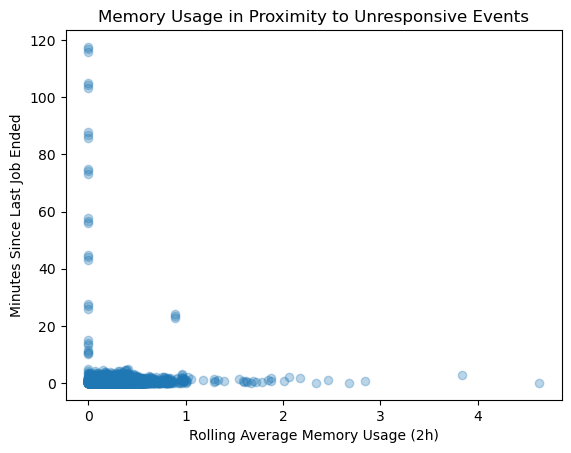

In [24]:
# Plot avg memory usage and time before unresponsive events
plt.scatter(
    job_features['avg_mem_use_2h'],
    job_features['mins_since_last_job_end'],
    alpha=0.3
)

plt.xlabel('Rolling Average Memory Usage (2h)')
plt.ylabel('Minutes Since Last Job Ended')
plt.title('Memory Usage in Proximity to Unresponsive Events')

plt.show();

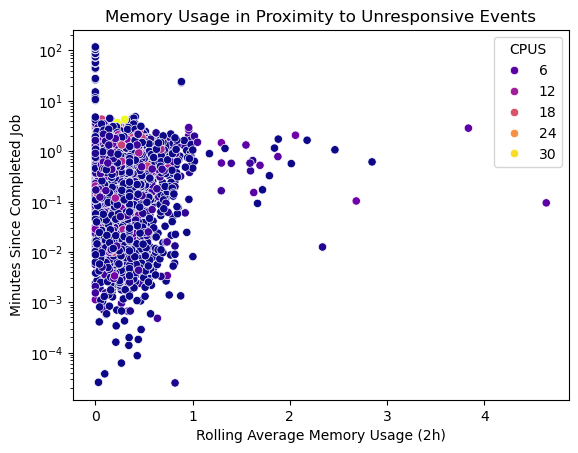

In [25]:
# Create different plot with Log Sale
sns.scatterplot(
    data = job_features, 
    x = 'avg_mem_use_2h', 
    y = 'mins_since_last_job_end', 
    hue = 'CPUS',
    palette = 'plasma'
)

plt.yscale('log')
plt.xlabel('Rolling Average Memory Usage (2h)')
plt.ylabel('Minutes Since Completed Job')
plt.title('Memory Usage in Proximity to Unresponsive Events')

plt.show();

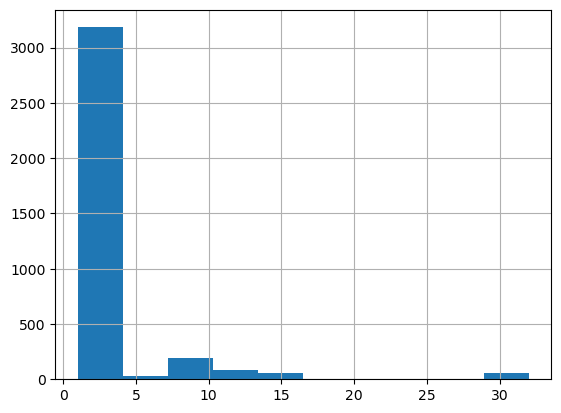

In [26]:
# Show distribution of CPUS in jobs before unresponsive events
job_features['CPUS'].hist();

In [27]:
# Create summary statistic table of explanatory variables
job_features[[
    'mem_usage',
    'avg_mem_use_2h',
    'mins_since_last_job_end',
    'CPUS'
]]. describe ()

,mem_usage,avg_mem_use_2h,mins_since_last_job_end,CPUS
count,3607.000000,3622.000000,3607.000000,3607.000000
mean,0.289515,0.284359,1.142586,2.894372
std,0.384727,0.248277,6.043352,4.786013
min,0.000000,0.000000,0.000025,1.000000
25%,0.047306,0.134316,0.074491,1.000000
50%,0.205862,0.245388,0.500541,1.000000
75%,0.443786,0.383883,1.042950,3.000000
max,7.388673,4.635554,117.625182,32.000000


In [28]:
# Create column with indicator for unresponsive event within 10 minutes of job
job_features['event_10m'] = (
    job_features['mins_since_last_job_end'] <= 10
).astype(int)

In [50]:
# Show correlation between events
job_features[['event_10m', 'avg_mem_use_2h']].corr()

,event_10m,avg_mem_use_2h
event_10m,1.000000,0.103532
avg_mem_use_2h,0.103532,1.000000


**Phase 4: Interpret and Conclude**  
Objectives:  
* Answer the main question: Does the data support the hypothesis that the slurm scheduler is more likely to be unresponsive during bursts of job completions?  
* Summarize findings and limitations.  

Notebook Sections:    
* Markdown: Summarize evidence for or against the hypothesis.  
* Markdown: Provide a clear conclusion.  

> ## Logistic Regression Models
>
> To formally test wether system load preceding job completions is associated with scheduler unresponsiveness, I have fit two logistic regression models predicting unresponsive events within 10 minuted of a completed job. The first model uses a two hour rolling average of memory usage preceding each unresponsive event. The second model uses the number of completed jobs within a 30min window to predict scheduler unresponsiveness.
>
>
>>Together, these models provide complimentary evidence that resource load and job completion density are related to scheduler unresponsiveness. Both coefficients have significant P-values and confidence intervals that do not contain zero.

In [29]:
# Logistic Regression to predict probability of unresponsive event within 10 mins
jobs_logreg = smf.logit("event_10m ~ avg_mem_use_2h",
                          data = job_features).fit()

Optimization terminated successfully.
         Current function value: 0.054097
         Iterations 11


In [30]:
jobs_logreg.params

Intercept          2.368056
avg_mem_use_2h    14.965868
dtype: float64

In [31]:
jobs_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              event_10m   No. Observations:                 3622
Model:                          Logit   Df Residuals:                     3620
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:                  0.2053
Time:                        12:02:05   Log-Likelihood:                -195.94
converged:                       True   LL-Null:                       -246.55
Covariance Type:            nonrobust   LLR p-value:                 8.248e-24
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.3681      0.198     11.965      0.000       1.980       2.756
avg_mem_use_2h    14.9659      2.133      7.017      0.000      10.786      19.146
==================================================================================

Possibly complete quasi-separation: A fraction 0.16 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [32]:
# Create column with number of jobs in last 30 mins
completed_jobs_rolling = completed_jobs.sort_values(by = 'END')
completed_jobs_rolling['num_jobs_30m'] = completed_jobs_rolling.rolling('30min', on='END')['JOBID'].count()

In [33]:
# Create column with number of jobs in last 30 mins
completed_jobs_rolling = completed_jobs.sort_values(by = 'END')
completed_jobs_rolling['num_jobs_30m'] = completed_jobs_rolling.rolling('30min', on='END')['JOBID'].count()

# Sort unresponsive events and completed job count before merge
events = job_features.sort_values('date_time')
number_of_jobs_30min_sort = completed_jobs_rolling[['END', 'num_jobs_30m']].sort_values('END')

# Merge rolling count of total complete jobs for each unresponsive event
jobs_rolling_count_30min = pd.merge_asof(
    events,
    number_of_jobs_30min_sort,
    left_on='date_time',
    right_on='END',
    direction='backward'
)

In [34]:
# Fit logistic regression model to predict probability of unresponsive event within 10 mins
job_burst_logreg = smf.logit('event_10m ~ num_jobs_30m',
                          data = jobs_rolling_count_30min).fit()

Optimization terminated successfully.
         Current function value: 0.029900
         Iterations 14


In [35]:
job_burst_logreg.params

Intercept      -0.388911
num_jobs_30m    0.070712
dtype: float64

In [36]:
job_burst_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              event_10m   No. Observations:                 3622
Model:                          Logit   Df Residuals:                     3620
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:                  0.5607
Time:                        12:02:07   Log-Likelihood:                -108.30
converged:                       True   LL-Null:                       -246.55
Covariance Type:            nonrobust   LLR p-value:                 4.350e-62
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3889      0.278     -1.397      0.162      -0.934       0.157
num_jobs_30m     0.0707      0.008      9.360      0.000       0.056       0.086
================================================================================

Possibly complete quasi-separation: A fraction 0.69 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**Final Deliverable:**
A single Jupyter notebook that includes:  
1. Introduction & dataset overview  
2. Data exploration & cleaning  
3. Feature engineering  
4. Analysis & visualizations  
5. Interpretation & conclusion